<a href="https://colab.research.google.com/github/Danm15/TMHLabs/blob/main/lab4_MelnykGorbPetrushchenko.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4

In [15]:

path_to_zipped_data = "/content/drive/MyDrive/TMH/lab 4/data/Cats_and_Dogs.zip"

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:

!unzip -nq "$path_to_zipped_data" -d "/content" && echo "Success!"

import pathlib
data_dir = pathlib.Path("Cats_and_Dogs/")

Success!


In [18]:

folders = [item.name for item in data_dir.iterdir() if item.is_dir()]

for folder in folders:
    path = data_dir / folder
    categories = [item.name for item in path.iterdir() if item.is_dir()]
    for category in categories:
        category_path = path / category
        print(f"{folder.capitalize()} {category}: {len(list(category_path.glob('*')))}")

print("\nExamples of some file names:")
for folder in folders:
    path = data_dir / folder
    categories = [item.name for item in path.iterdir() if item.is_dir()]
    for category in categories:
        category_path = path / category
        print(f"{folder.capitalize()} {category}:")
        for file in list(category_path.glob('*'))[:3]:
            print(file)

Train dogs: 10000
Train cats: 10000
Test dogs: 1250
Test cats: 1250
Val dogs: 1250
Val cats: 1240

Examples of some file names:
Train dogs:
Cats_and_Dogs/train/dogs/dog.3739.jpg
Cats_and_Dogs/train/dogs/dog.4683.jpg
Cats_and_Dogs/train/dogs/dog.9931.jpg
Train cats:
Cats_and_Dogs/train/cats/cat.3247.jpg
Cats_and_Dogs/train/cats/cat.5706.jpg
Cats_and_Dogs/train/cats/cat.5032.jpg
Test dogs:
Cats_and_Dogs/test/dogs/dog.10306.jpg
Cats_and_Dogs/test/dogs/dog.10209.jpg
Cats_and_Dogs/test/dogs/dog.10310.jpg
Test cats:
Cats_and_Dogs/test/cats/cat.10608.jpg
Cats_and_Dogs/test/cats/cat.11173.jpg
Cats_and_Dogs/test/cats/cat.10558.jpg
Val dogs:
Cats_and_Dogs/val/dogs/dog.12382.jpg
Cats_and_Dogs/val/dogs/dog.11333.jpg
Cats_and_Dogs/val/dogs/dog.12296.jpg
Val cats:
Cats_and_Dogs/val/cats/cat.12078.jpg
Cats_and_Dogs/val/cats/cat.12288.jpg
Cats_and_Dogs/val/cats/cat.11564.jpg


In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.applications import VGG19, ResNet50
from keras.callbacks import EarlyStopping

---

<br /><br /><br />

# Tasks

1. Завантажте дані.

2. Побудуйте модель класифікації зібраних у датасеті зображень на собак і кішок.
Для цього послідовно реалізуйте:
- а) повнозв’язну мережу з трьома прихованими шарами для класифікації
зображень (на вхід - одновимірний вектор)
- б) згорткову нейронну мережу з двома блоками згортання і субдискретизації для
тієї самої мети.

3. реалізуйте перенесення навчання для моделей VGG19 і ResNet, скориставшись
вагами попередньо навчених моделей, «заморозивши» повнозв’язні шари і
перенавчивши їх на нових даних.

4. Порівняйте продуктивність моделей.

5. Збільшіть число епох навчання для моделей (а) і (б) і побудуйте криві навчання, що демонструють явище перенавчання.


In [20]:
img_height, img_width = 128, 128
batch_size = 32

def load_dataset(directory):
    ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )
    class_names = ds.class_names

    normalization_layer = tf.keras.layers.Rescaling(1./255)
    normalized_ds = ds.map(lambda x, y: (normalization_layer(x), y))
    return normalized_ds, class_names


train_ds, class_names = load_dataset(data_dir/'train')
val_ds, _ = load_dataset(data_dir/'val')
test_ds, _ = load_dataset(data_dir/'test')

print('\n', class_names)

Found 20000 files belonging to 2 classes.
Found 2490 files belonging to 2 classes.
Found 2500 files belonging to 2 classes.

 ['cats', 'dogs']


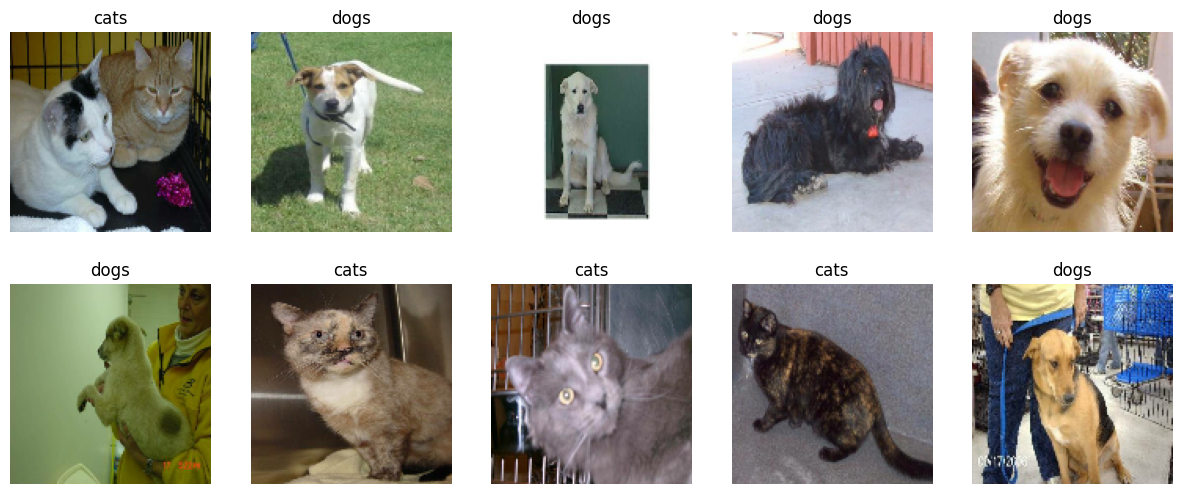

In [21]:
plt.figure(figsize=(15, 6))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Configure the dataset for performance

from this guide: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb#scrollTo=Ti8avTlLofoJ

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

---

<br /><br /><br /><br />

## 2. Build the models

а) повнозв’язну мережу з трьома прихованими шарами для класифікації зображень (на вхід - одновимірний вектор)

б) згорткову нейронну мережу з двома блоками згортання і субдискретизації для тієї самої мети.

In [25]:

model_fc = Sequential()
model_fc.add(Flatten(input_shape=(128, 128, 3)))
model_fc.add(Dense(512, activation='relu'))
model_fc.add(Dense(256, activation='relu'))
model_fc.add(Dense(128, activation='relu'))


model_fc.add(Dense(1, activation='sigmoid'))

In [24]:

model_cnn = Sequential()


model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Flatten())

model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

## 3. Transfer Learning with VGG19 and ResNet

реалізуйте перенесення навчання для моделей VGG19 і ResNet, скориставшись
вагами попередньо навчених моделей, «заморозивши» повнозв’язні шари і
перенавчивши їх на нових даних.

In [27]:

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
model_vgg19 = Sequential()
model_vgg19.add(base_model)
model_vgg19.add(Flatten())
model_vgg19.add(Dense(128, activation='relu'))
model_vgg19.add(Dropout(0.5))
model_vgg19.add(Dense(1, activation='sigmoid'))

for layer in base_model.layers:
    layer.trainable = False


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
model_resnet = Sequential()
model_resnet.add(base_model)
model_resnet.add(Flatten())
model_resnet.add(Dense(128, activation='relu'))
model_resnet.add(Dropout(0.5))
model_resnet.add(Dense(1, activation='sigmoid'))

for layer in base_model.layers:
    layer.trainable = False


## 4. Порівняйте продуктивність моделей.

In [28]:

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [ ]:
# ~15 min  (~ 100s + 120s + 360s + 300s)

# Compile and train the models
models = {
    'Fully-connected': model_fc,
    'Convolutional': model_cnn,
    'VGG19': model_vgg19,
    'ResNet50': model_resnet
}
histories = {}

for name, model in models.items():
    print(f"\nTraining model: {name}")
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    history = model.fit(
        train_ds,
        epochs=10,
        validation_data=val_ds,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
    )
    histories[name] = history


Training model: Fully-connected
Epoch 1/10
625/625 [==============================] - 35s 53ms/step - loss: 1.0327 - accuracy: 0.5494 - val_loss: 0.6689 - val_accuracy: 0.5843
Epoch 2/10


In [ ]:
# Testing the models
for name, model in models.items():
    print(f"\nTesting model: {name}")
    loss, accuracy = model.evaluate(test_ds)


Testing model: Fully-connected
79/79 [==============================] - 3s 35ms/step - loss: 0.6530 - accuracy: 0.6164

Testing model: Convolutional
79/79 [==============================] - 2s 25ms/step - loss: 1.0481 - accuracy: 0.7644

Testing model: VGG19
79/79 [==============================] - 4s 53ms/step - loss: 0.2930 - accuracy: 0.8736

Testing model: ResNet50
79/79 [==============================] - 5s 54ms/step - loss: 0.5662 - accuracy: 0.7312


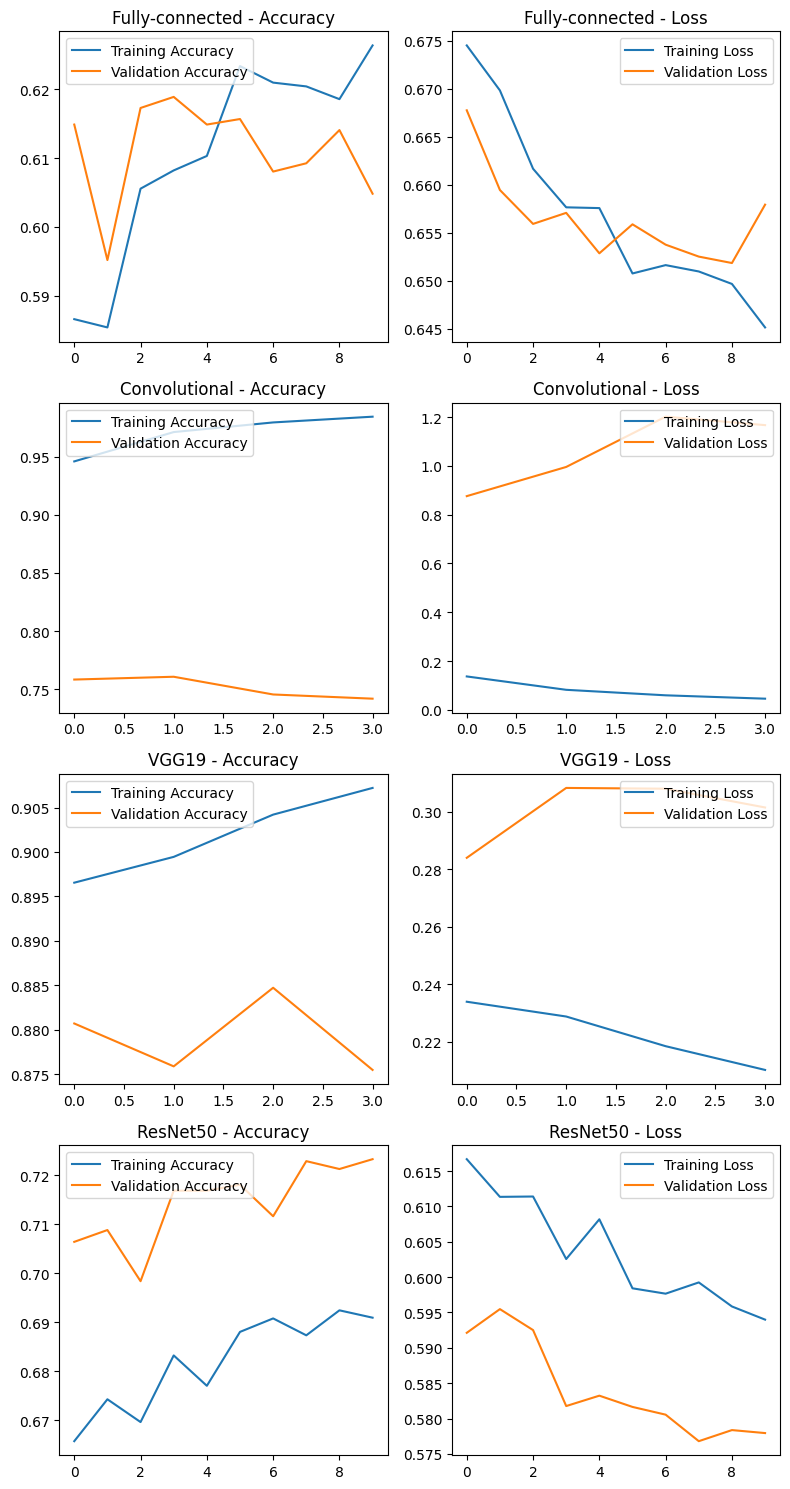

In [ ]:
# Compare:
# Plot the loss and accuracy for each model

fig, axs = plt.subplots(4, 2, figsize=(8, 15))  # one model per row: accuracy & loss

for i, (name, history) in enumerate(histories.items()):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    axs[i, 0].plot(epochs_range, acc, label='Training Accuracy')
    axs[i, 0].plot(epochs_range, val_acc, label='Validation Accuracy')
    axs[i, 0].legend(loc='upper left')
    axs[i, 0].set_title(f'{name} - Accuracy')

    axs[i, 1].plot(epochs_range, loss, label='Training Loss')
    axs[i, 1].plot(epochs_range, val_loss, label='Validation Loss')
    axs[i, 1].legend(loc='upper right')
    axs[i, 1].set_title(f'{name} - Loss')

plt.tight_layout()
plt.show()


## 5. Збільшіть число епох навчання для моделей (а) і (б) <br /> і побудуйте криві навчання, що демонструють явище перенавчання.

In [ ]:
# ~7 min  (~ 180s + 240s)

# Compile and train the models
overfit_models = {
    'Fully-connected': model_fc,
    'Convolutional': model_cnn,
}
overfit_histories = {}

for name, model in overfit_models.items():
    print(f"\nTraining model: {name}")
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy'],
    )
    history = model.fit(
        train_ds,
        epochs=12,
        validation_data=val_ds,
    )
    overfit_histories[name] = history


Training model: Fully-connected
Epoch 1/12
625/625 [==============================] - 9s 13ms/step - loss: 0.6299 - accuracy: 0.6446 - val_loss: 0.6685 - val_accuracy: 0.5859
Epoch 2/12
625/625 [==============================] - 8s 12ms/step - loss: 0.6309 - accuracy: 0.6445 - val_loss: 0.6536 - val_accuracy: 0.6189
Epoch 3/12
625/625 [==============================] - 7s 11ms/step - loss: 0.6353 - accuracy: 0.6348 - val_loss: 0.6639 - val_accuracy: 0.6209
Epoch 4/12
625/625 [==============================] - 7s 12ms/step - loss: 0.6314 - accuracy: 0.6391 - val_loss: 0.6518 - val_accuracy: 0.6249
Epoch 5/12
625/625 [==============================] - 9s 14ms/step - loss: 0.6297 - accuracy: 0.6434 - val_loss: 0.6498 - val_accuracy: 0.6261
Epoch 6/12
625/625 [==============================] - 7s 12ms/step - loss: 0.6268 - accuracy: 0.6490 - val_loss: 0.6582 - val_accuracy: 0.6249
Epoch 7/12
625/625 [==============================] - 8s 12ms/step - loss: 0.6344 - accuracy: 0.6345 - val_lo

In [ ]:
# Testing the models
for name, model in overfit_models.items():
    print(f"\nTesting model: {name}")
    loss, accuracy = model.evaluate(test_ds)


Testing model: Fully-connected
79/79 [==============================] - 2s 26ms/step - loss: 0.6619 - accuracy: 0.6220

Testing model: Convolutional
79/79 [==============================] - 2s 27ms/step - loss: 2.0397 - accuracy: 0.7552


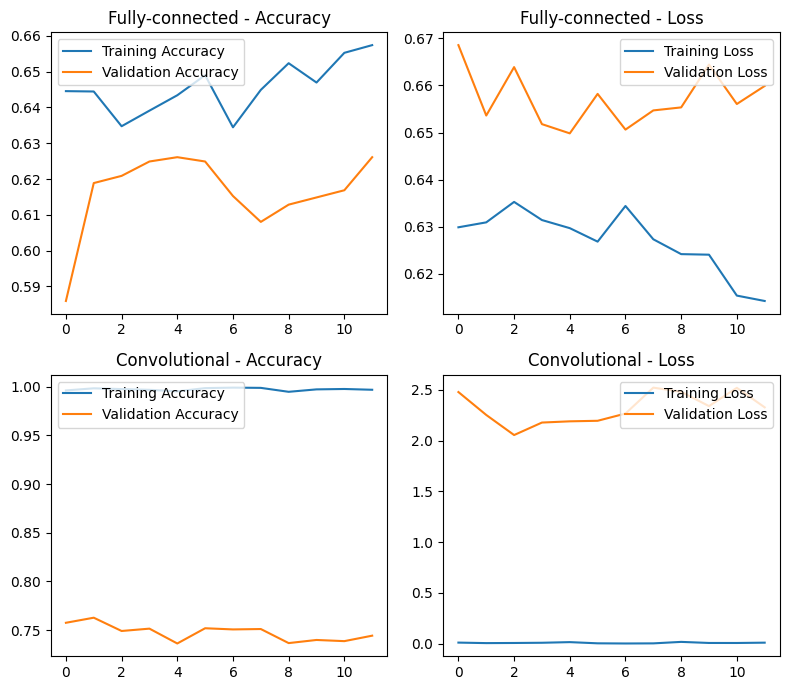

In [ ]:
# Compare:
# Plot the loss and accuracy for each model

fig, axs = plt.subplots(2, 2, figsize=(8, 7))  # one model per row: accuracy & loss

for i, (name, history) in enumerate(overfit_histories.items()):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    axs[i, 0].plot(epochs_range, acc, label='Training Accuracy')
    axs[i, 0].plot(epochs_range, val_acc, label='Validation Accuracy')
    axs[i, 0].legend(loc='upper left')
    axs[i, 0].set_title(f'{name} - Accuracy')

    axs[i, 1].plot(epochs_range, loss, label='Training Loss')
    axs[i, 1].plot(epochs_range, val_loss, label='Validation Loss')
    axs[i, 1].legend(loc='upper right')
    axs[i, 1].set_title(f'{name} - Loss')

plt.tight_layout()
plt.show()
